In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-stock-prices-20152020/AAPL.csv


In [70]:
df = pd.read_csv('../input/apple-stock-prices-20152020/AAPL.csv')

In [71]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [72]:
df.shape

(1258, 15)

In [73]:
df.isnull().sum()

Unnamed: 0     0
symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

We are performing the prediction/forecasting on 'close' column 


In [74]:
df1 = df.reset_index()['close']

In [75]:
df1


0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

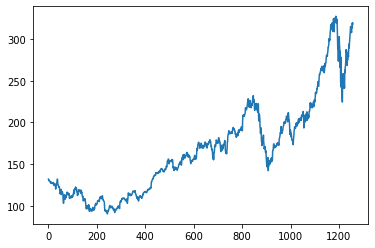

In [76]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.plot(df1)

In [77]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [78]:
df1.shape

(1258, 1)

In [79]:
##splitting dataset into train and test split
train_size = int(len(df1)*0.65)
train_data,test_data = df1[0:train_size,:],df1[train_size:len(df1),:1]

In [80]:
train_size

817

In [81]:
#Data Preprocessing
# convert an array of values into a dataset matrix

def create_ds(dataset,time_steps):   #Time Steps is how many previous records considered to predict the current record
    data_x,data_y = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps),0]
        data_x.append(a)
        b = dataset[i+time_steps,0]
        data_y.append(b)
    return np.array(data_x),np.array(data_y)
    
    

In [82]:
time_step = 100
X_train, y_train = create_ds(train_data, time_step)
X_test, ytest = create_ds(test_data, time_step)

In [83]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [84]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [85]:
#Before feeding into lstm we must convert dataset into 3d 
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [86]:
#Model Creation 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [87]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [88]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 114ms/step - loss: 0.0375 - val_loss: 0.0564
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 7.9449e-04 - val_loss: 0.0051
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 7.1347e-04 - val_loss: 0.0051
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 6.0147e-04 - val_loss: 0.0038
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 5.9940e-04 - val_loss: 0.0037
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 5.9831e-04 - val_loss: 0.0040
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 6.0603e-04 - val_loss: 0.0037
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss: 

In [90]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [91]:
# We have scaled it, so we need to reverse scale it to find the o/p
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [92]:
#rmse
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

141.69651119814125

In [93]:
math.sqrt(mean_squared_error(ytest,test_predict))

237.19831614561352

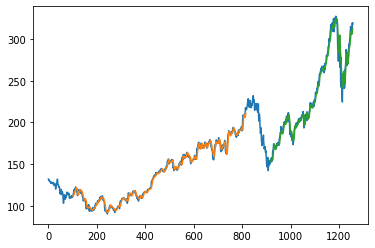

In [94]:
plt.plot(scaler.inverse_transform(df1))
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
plt.plot(trainPredictPlot)
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.plot(testPredictPlot)

In [95]:
#predicting future 30 days
#For predicting next day after last test data, we need to take previous 100 values(timestep)
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [96]:
x_input

array([[0.85835515, 0.8866419 , 0.87431394, 0.88431985, 0.87836697,
        0.8986321 , 0.92582116, 0.92877649, 0.95676771, 0.93869797,
        0.93304061, 0.94950604, 0.96424048, 0.95512117, 0.95989192,
        0.96635143, 0.96246728, 0.92295027, 0.9598497 , 0.98792536,
        0.98594106, 0.92531453, 0.92172591, 0.96474711, 0.97572406,
        0.99159841, 0.96972895, 0.97614625, 0.96795575, 1.        ,
        0.99016297, 0.99050072, 0.96538039, 0.98488559, 0.97086887,
        0.94026007, 0.87748037, 0.83483915, 0.85413324, 0.77336823,
        0.77269273, 0.88014017, 0.84007431, 0.89673225, 0.85527316,
        0.83884995, 0.74233725, 0.82327113, 0.78143207, 0.6665963 ,
        0.7921557 , 0.64118044, 0.68614371, 0.66001013, 0.65203074,
        0.58642236, 0.56586169, 0.66089673, 0.65515494, 0.70970193,
        0.66452757, 0.69437642, 0.69218104, 0.63569197, 0.65266402,
        0.63780292, 0.7267162 , 0.71388162, 0.74191506, 0.75002111,
        0.77222832, 0.83049059, 0.8194292 , 0.82

In [97]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [98]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [99]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

[0.9544915]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

In [100]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

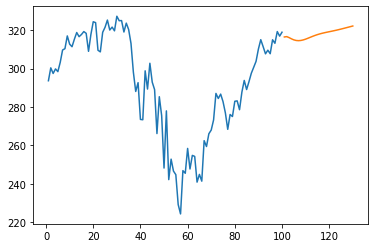

In [101]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

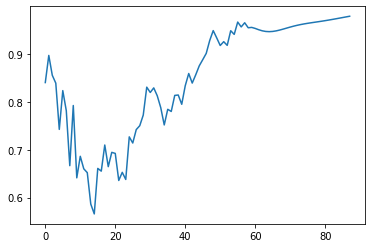

In [102]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [103]:
df3=scaler.inverse_transform(df3).tolist()

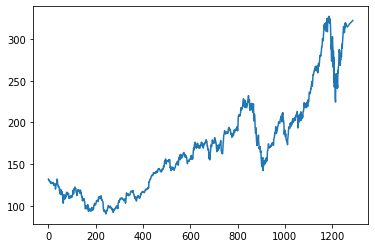

In [104]:
plt.plot(df3)